#### Lab Design 1 - Generating Synthetic Data and Binary Classification. 

In [17]:
# Importing required libraries.

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

#### Data Generation!

In [18]:
# desc: This function creates sythetic data points that approximate a circle.
def generate_shapeCircle(n_samples, radius=1.0, noise=0.1):
    angles = 2 * np.pi * np.random.rand(n_samples)
    radii = radius + noise * np.random.randn(n_samples)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    labels = np.zeros(n_samples)
    return np.column_stack((x, y)), labels

In [19]:
# desc: This function creates synthetic data points that approximate a square.
def generate_shapeSquare(n_samples, side=2.0, noise=0.1):
    x = (np.random.rand(n_samples) - 0.5) * side
    y = (np.random.rand(n_samples) - 0.5) * side
    x += noise * np.random.randn(n_samples)
    y += noise * np.random.randn(n_samples)
    labels = np.ones(n_samples)
    return np.column_stack((x, y)), labels

In [20]:
# Generating Data.
n_samples = 500

# Generating circle data.
circle_datapoints, circle_labels = generate_shapeCircle(n_samples)

# Generating square data.
square_datapoints, square_labels = generate_shapeSquare(n_samples)

In [21]:
# Combining the datasets.

# Vertically stacking the circle and square data points into a single array.
X = np.vstack((circle_datapoints, square_datapoints))

# Horizontally stacking the labels of both shapes.
y = np.hstack((circle_labels, square_labels))

In [22]:
# Splitting the data into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

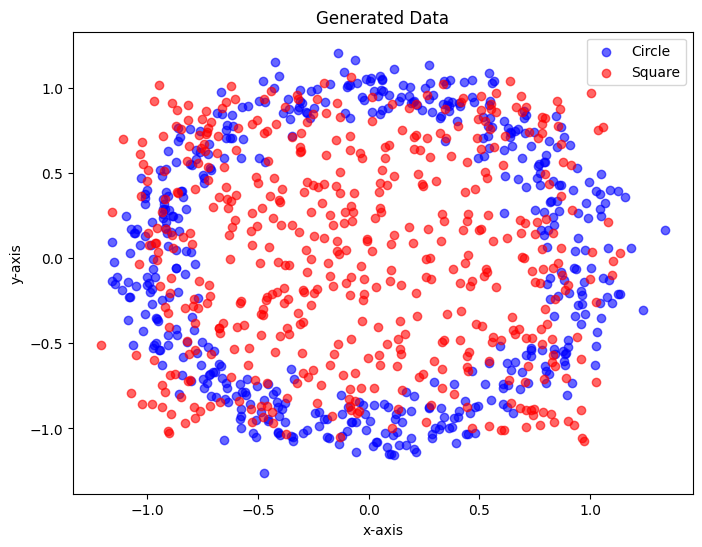

In [23]:
# Visualizing the generated data.

plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='blue', label="Circle", alpha=0.6)

plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='red', label="Square", alpha=0.6)

plt.title("Generated Data")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.legend()

plt.show()

In [24]:
# Converting the data into tensors.

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#### Model Building!

In [25]:
# Defining the class.

class ShapeClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ShapeClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [26]:
# Creating an instance of the model.

model = ShapeClassifier(input_dim=2)

In [27]:
# Loss and Optimizer.

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [28]:
# Training.

numberOfEpochs = 200
losses = []

for epoch in range(numberOfEpochs):
    model.train()
    
    # Forward Passing.
    outputs = model(X_train_tensor)
    loss = loss_criterion(outputs, y_train_tensor)
    
    # Optimization - Backward Propagation.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if epoch % 10 == 0 or epoch == 100:  
        print(f"Epoch [{epoch}/{numberOfEpochs}], Loss: {loss.item():.4f}")

Epoch [0/200], Loss: 0.6955
Epoch [10/200], Loss: 0.6825
Epoch [20/200], Loss: 0.6653
Epoch [30/200], Loss: 0.6366
Epoch [40/200], Loss: 0.5985
Epoch [50/200], Loss: 0.5614
Epoch [60/200], Loss: 0.5356
Epoch [70/200], Loss: 0.5232
Epoch [80/200], Loss: 0.5125
Epoch [90/200], Loss: 0.5027
Epoch [100/200], Loss: 0.4970
Epoch [110/200], Loss: 0.4913
Epoch [120/200], Loss: 0.4862
Epoch [130/200], Loss: 0.4800
Epoch [140/200], Loss: 0.4742
Epoch [150/200], Loss: 0.4701
Epoch [160/200], Loss: 0.4673
Epoch [170/200], Loss: 0.4644
Epoch [180/200], Loss: 0.4622
Epoch [190/200], Loss: 0.4599


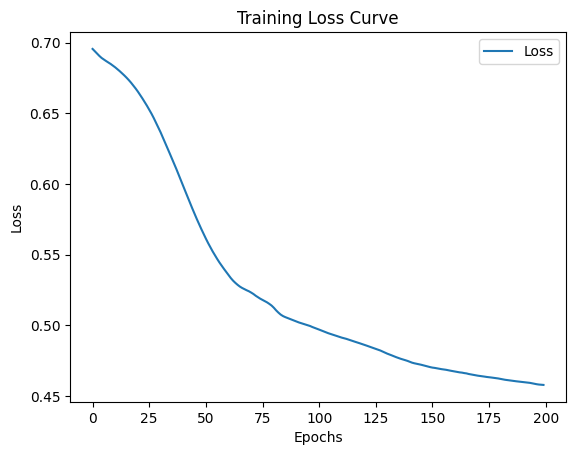

In [29]:
# Plotting the training loss curve.

plt.plot(range(numberOfEpochs), losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()


#### Evaluating the model!

In [30]:
model.eval()
with torch.no_grad():
    y_train_pred = torch.argmax(model(X_train_tensor), dim=1).numpy()
    y_test_pred = torch.argmax(model(X_test_tensor), dim=1).numpy()

# Testing.

train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Train Accuracy: 77.73%
Test Accuracy: 71.60%


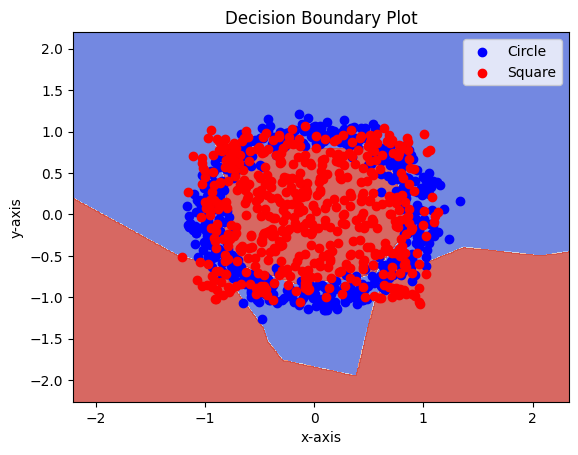

In [31]:
# Visualizing the decision boundary created.

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = torch.argmax(model(grid_tensor), axis=1).numpy()
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='blue', label="Circle")
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='red', label="Square")
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.legend()
    plt.show()

plot_decision_boundary(model, X, y, title="Decision Boundary Plot")